Creando rutinas de preprocesamiento con Scikit-Learn
====================================================

## Introducción

TODO

## Creando una rutina de preprocesamiento en el problema censo de la UCI

Veamos como crear una rutina de preprocesamiento para el conjunto de datos del problema de censo de la UCI.

### Instalación

Necesitaremos instalar las librerias:

In [ ]:
!pip install cloudpickle --quiet

### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [1]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

Lo importamos

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

In [3]:
train

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,<=50K,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,>50K,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,<=50K,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,<=50K,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


### Explorando las distribuciones de las variables

Veamos algo de información sobre este conjunto de datos:

In [4]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Utilizaremos la siguiente rutina para ir verificando los cambios que realizamos en el conjunto de datos. La misma muestra la cantidad de muestras, la cantidad de predictores y algunos valores interesantes en el caso que indiquemos alguna columna para mostrar. Este paso no es necesario en una rutina de preprocesamiento pero simplemente nos ayuda a verificar los cambios que realizamos.

In [5]:
from typing import List, Tuple

def print_stats(df: pd.DataFrame, detail_columns: List[str] = None):
  print(f"Muestras:", df.shape[0])
  print(f"Features:", df.shape[1])
  print(f"Faltantes:", df.isna().sum().sum())

  if detail_columns:
    print('Detalles:')
    for column in detail_columns:
      print(f"\tColumna: {column} ({df[column].dtype})")
      if df[column].dtype in ['O', 'Object', 'int64']:
        print(f"\t\tValores únicos: {len(df[column].unique())}")
        print(f"\t\Faltantes: {df[column].isna().sum()}")
      if df[column].dtype in ['float32', 'float64']:
        print(f"\t\tMedia: {df[column].mean()}")


Por ejemplo, podemos utilizarla como sigue:

In [6]:
print_stats(train)

Muestras: 32561
Features: 15
Faltantes: 0


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

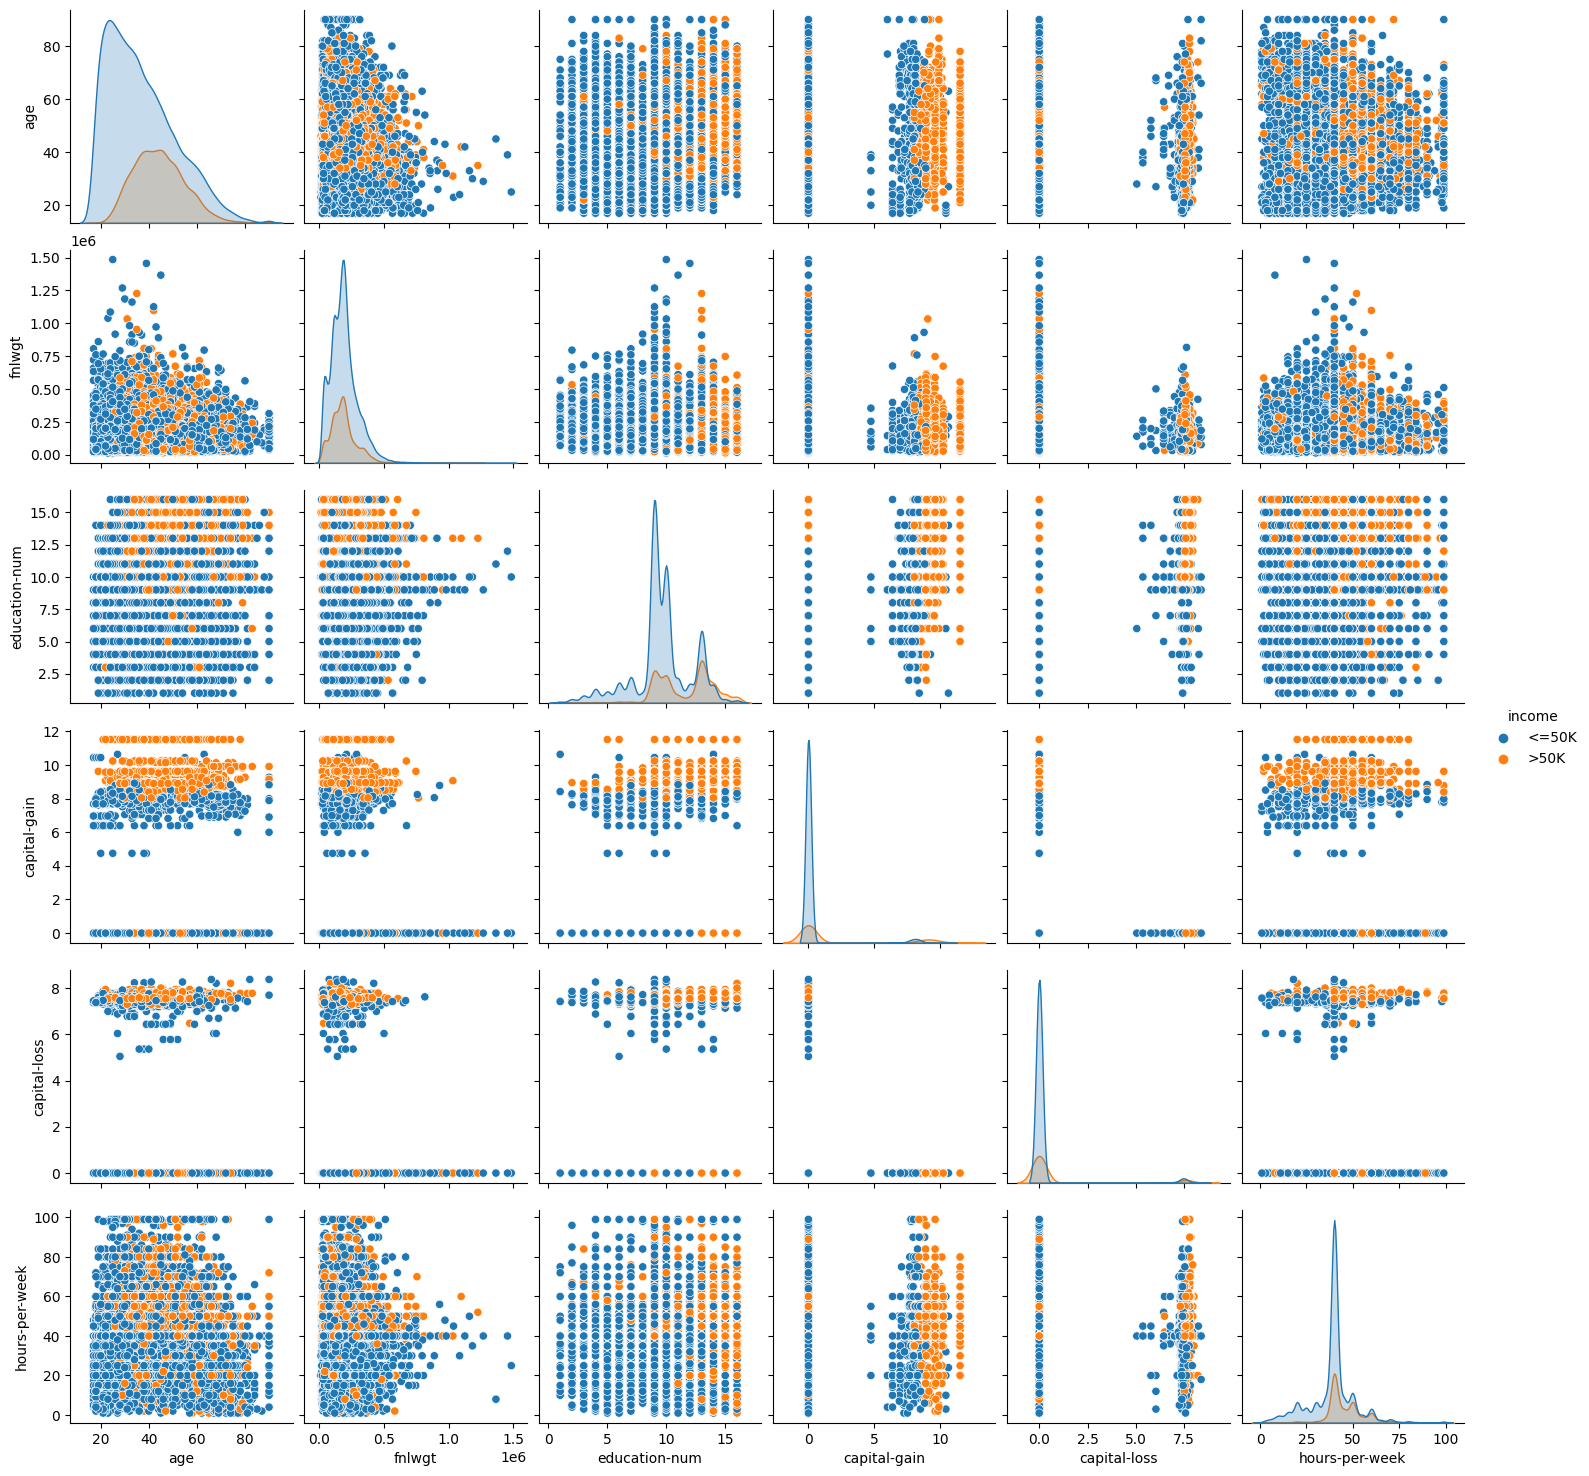

In [45]:
sns.pairplot(train, hue="income")

### Preprocesando los datos

Veamos a modo de ejemplo multiple preprocesamientos que podemos realizar:

#### Procesamos valores faltantes

En este conjunto de datos, los valores faltantes estan codifícados muchas veces como "?". Podemos reemplazar este valor por el correspondiente valor faltante para identificarlos mejor:

In [9]:
train.replace(' ?', np.nan, inplace=True)

In [10]:
print_stats(train)

Muestras: 32561
Features: 15
Faltantes: 4262


#### Correjiendo calidad de datos

Muchas variables, adicionalmente, tienen el problema que sus valores poseen "espacios" en blanco que son dificiles de divisar. Por ejemplo el valor " married" (note el espacio al principio del texto). Eliminaremos estos espacios en blanco con la función `lstrip()`.

In [44]:
for col in train.dtypes[train.dtypes == 'object' ].keys():
  train[col] = train[col].str.lstrip()

> Tip: En Numpy, strings son almacenadas como tipo `object`.

#### Corrección de tipos de datos

Algunas variables podríamos necesitarlas en otro tipo de dato. Por ejemplo, podríamos necesitar la variable edad que esté codificada como entera en lugar de como punto flotante:

In [201]:
train["age"] = train["age"].astype(int)

In [202]:
train["age"].dtype

dtype('int64')

#### Eliminando registros duplicados

En algunos casos, puede ser util eliminar regitros que son duplicados. En general, la mayoria de los algoritmos de aprendizaje suelen ser robustos a este tipo de características.

In [203]:
train.drop_duplicates(inplace=True)

In [204]:
print_stats(train)

Muestras: 32537
Features: 15
Faltantes: 0


#### Eliminamos valores faltantes en la columna a predecir

Los valores faltantes en la columna a predecir no pueden ser inputados, y por lo tanto suelen ser eliminados directamente del conjunto de datos:

In [13]:
train.dropna(axis='index', subset=['income'], inplace=True)

In [14]:
print_stats(train)

Muestras: 32537
Features: 15
Faltantes: 4261


#### Reagrupando variables categoricas

En algunas ocaciones, algunas variables categóricas que tienen muchos valores pueden introducir un problema de dimensionalidad al codificarlas, especialmente si utilizamos one-hot encoding. Podemos explorar la distribución y identificar si podemos reagruparlas:

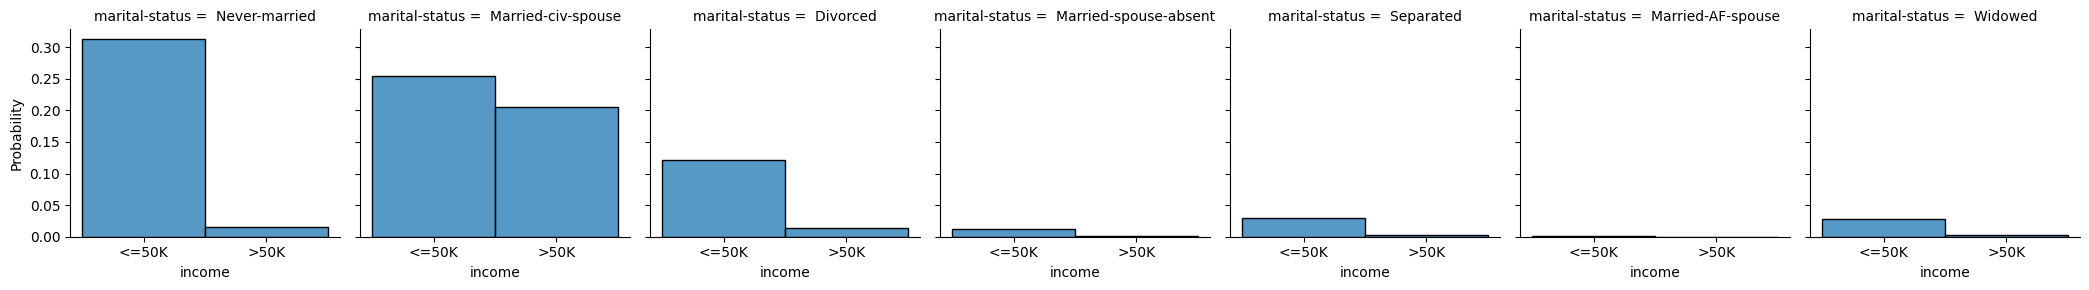

In [15]:
sns.displot(train, x="income", stat="probability", col="marital-status", height=3)

Agrupamos entonces las diferentes categorías de la siguiente forma:

In [17]:
mapping = {
  'Divorced': 'Single',
  'Married-spouse-absent': 'Single',
  'Never-married': 'Single',
  'Separated': 'Single',
  'Widowed': 'Single',
  'Married-AF-spouse': 'Couple',
  'Married-civ-spouse': 'Couple',
}

La función `map()` nos permite mapear los valores a otro conjunto de valores utilizando un diccionario como entrada:

In [18]:
train['marital-status'] = train['marital-status'].map(mapping)

Verifiquemos la nueva distribución:

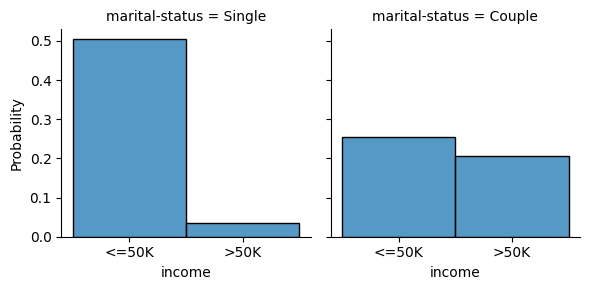

In [19]:
sns.displot(train, x="income", stat="probability", col="marital-status", height=3)

#### Tranformamos columnas a una escala logaritmica

En general, las variables que involugran precios suelen (en algunas ocaciones, mostrar distribuciones exponenciales.

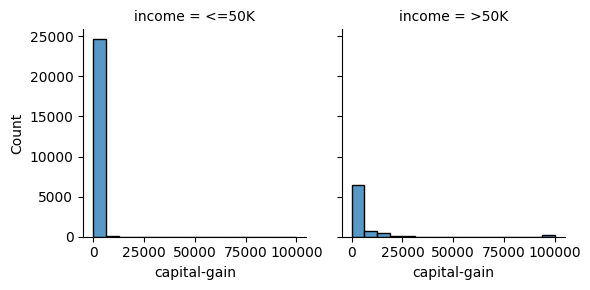

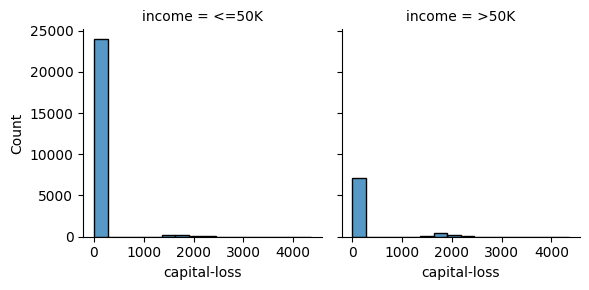

In [20]:
sns.displot(train, x="capital-gain", col="income", height=3)
sns.displot(train, x="capital-loss", col="income", height=3)

> Note que existe una gran cantidad de instancias con valor cero en estas columnas. Podríamos generar una columna indicadora para capturar este hecho si es que el algoritmo de aprendizaje no puede distinguirlo.

Verifiquemos que sucede si aplicamos el logarítmo natural:

In [21]:
train['capital-gain'] = np.log(train['capital-gain'] + 1)
train['capital-loss'] = np.log(train['capital-loss'] + 1)

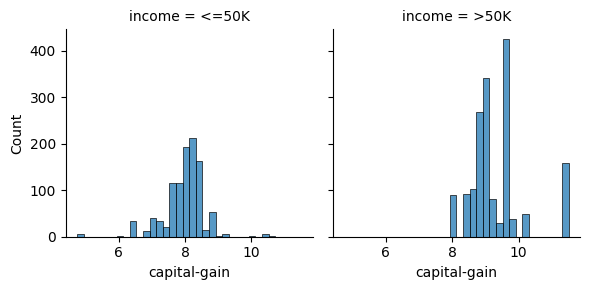

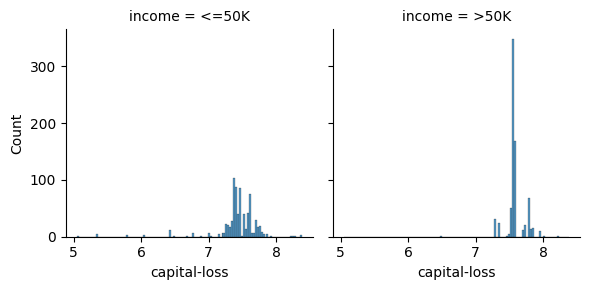

In [25]:
sns.displot(train[train['capital-gain'] > 0], x="capital-gain", col="income", height=3)
sns.displot(train[train['capital-loss'] > 0], x="capital-loss", col="income", height=3)

Veamos que tenemos distribuciones que resultan mucho más informativas.

### Empaquetando las transformaciones

Estas transformaciones deben aplicarse a todos los conjuntos de datos. Una forma de realizarlo es utilizando `scikit-learn` y empaquetar todas las transformaciones.

Crearemos entonces una función llamada `preprocess_uci` la cual contendra los pasos que mencionamos anteriormente en una única rutina:

In [205]:
def preprocess_uci(X, y=None):
    val = X.copy()
    val.replace(' ?', np.nan, inplace=True)

    for col in val.dtypes[X.dtypes == 'object' ].keys():
        val[col] = val[col].str.lstrip()

    if 'marital-status' in val.columns:
        mapping = {
          'Divorced': 'Single',
          'Married-spouse-absent': 'Single',
          'Never-married': 'Single',
          'Separated': 'Single',
          'Widowed': 'Single',
          'Married-AF-spouse': 'Couple',
          'Married-civ-spouse': 'Couple',
        }

        val['marital-status'] = val['marital-status'].map(mapping)

    if 'capital-gain' in val.columns:
        val['capital-gain'] = np.log(val['capital-gain'] + 1)
        val['capital-loss'] = np.log(val['capital-loss'] + 1)

    return val

Esta función la utilizaremos como uno de los pasos intermedios de una rutina de preprocesamiento más grande que adicionalmente escalará los valores y realizará la codificación de variables categóricas.

Lucira de la siguiente forma:

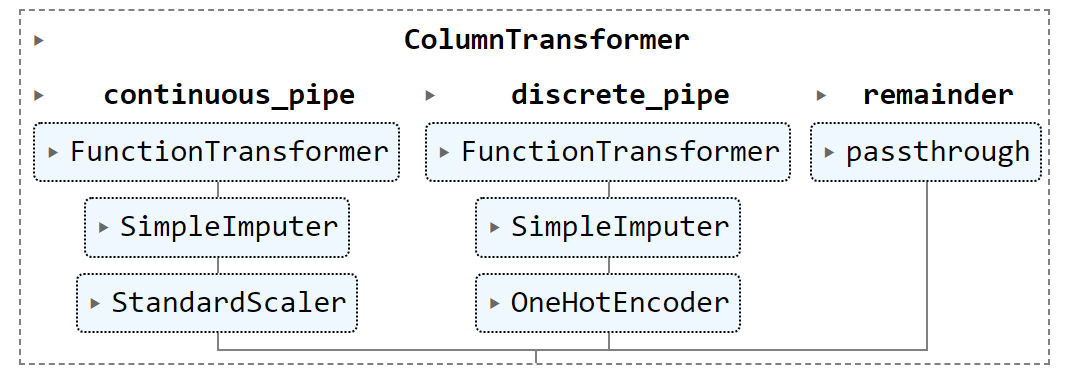

In [223]:
from typing import Tuple, List

import sklearn
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def prepare(X: pd.DataFrame, transformations: sklearn.compose.ColumnTransformer = None) -> Tuple[pd.DataFrame, sklearn.compose.ColumnTransformer]:
    """
    Preprocesasa los deferentes valores de un conjunto de datos.

    Parameters
    ----------
    X: pd.DataFrame:
        Connto de datos a transformar
    transformations: sklearn.compose.ComlumnTransformer
        Transformaciones que se deben aplicar al conjunto de datos. Si no son indicadas, las mismas son aprendidas desde el conjunto de datos.

    Returns: Tuple[pd.DataFrame, sklearn.compose.ColumnTransformer]
        Una tupla donde el primer component es el conjunto de datos transformado y el segundo las transformaciones que se aplicaron.
    """
    features = {
        'discrete': X.dtypes[X.dtypes == 'object' ].index.tolist(),
        'continuous': X.dtypes[X.dtypes != 'object'].index.tolist(),
    }

    num_pipe = Pipeline([
        ('preprocess', FunctionTransformer(func=preprocess_uci)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('preprocess', FunctionTransformer(func=preprocess_uci)),
        ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    if transformations is None:
        transformations = ColumnTransformer(
            [
              ('continuous_pipe', num_pipe, features['continuous']),
              ('discrete_pipe', cat_pipe, features['discrete']),
            ],
            remainder='passthrough')

        X = transformations.fit_transform(X)
    else:
        X = transformations.transform(X)

    transformed_discrete_features = transformations.transformers_[1][1].named_steps['encoder'].get_feature_names_out(features['discrete'])
    all_features = features['continuous'] + list(transformed_discrete_features)

    return pd.DataFrame(X, columns=all_features), transformations

La ventaja de realizar las transformaciones de esta forma es que la función `prepare` no solo retorna los datos preprocesados sino que también un objeto que contiene cualquier valor que haya sido aprendido del proceso de transformación.

Note que si pasamos como argumento `transformations` entonces la rutina no aprende ningun coeficiente sino que utiliza los que nosotros le indicamos.

Veamos como esto termina siendo util:

#### Generando los conjuntos de datos

Generaremos 3 conjuntos de datos: entrenamiento, validación y testing.

In [224]:
train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

In [229]:
from sklearn.model_selection import train_test_split

validation = test
test, _ = train_test_split(test, test_size=0.9, random_state=1234)

Separemos los predictores de la variable a predecir:

In [230]:
X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()
X_val = validation.drop(['income'], axis=1)
y_val = validation['income'].to_numpy()

Necesitamos preprocesar el conjunto de entrenamiento:

In [231]:
X_train_transformed, transformations = prepare(X_train)

Debemos ahora realizar las mismas transoformaciones sobre los otros dos conjuntos. Sin embargo, queremos aplicar los mismos coeficientes que aprendimos del conjunto de entrenamiento. Para ello simplemente pasamos como parametro las transformaciones:

In [232]:
X_test_transformed, _ = prepare(X_test, transformations)
X_val_transformed, _ = prepare(X_val, transformations)

#### Persisitiendo transformaciones

La ventaja de generar la rutina de preprocesamiento de esta forma es que ahora en `transformations`, tenemos todas las tranformaciones almacenadas y podemos guardarlas para luego aplicarlas:

In [211]:
import pickle
import cloudpickle

with open('transformations.pkl', 'wb') as f:
    cloudpickle.dump(transformations, f)

Podemos cargarlas y aplicarlas a un nuevo conjunto de datos:

In [233]:
with open('transformations.pkl', 'rb') as f:
  transoformations = pickle.load(f)

In [213]:
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()

In [214]:
X_test_transformed, _ = prepare(X_test, transformations)

In [215]:
X_test_transformed

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_NA,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.995706,0.350774,-1.197459,-0.299271,-0.221075,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.042642,-0.947095,-0.420060,-0.299271,-0.221075,0.774468,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.775768,1.394362,0.746039,-0.299271,-0.221075,-0.035429,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.397233,-0.279070,-0.031360,3.345796,-0.221075,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.508894,-0.817458,-0.031360,-0.299271,-0.221075,-0.845327,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,0.030671,0.242928,1.134739,-0.299271,-0.221075,-0.359389,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16277,1.863485,1.247055,-0.420060,-0.299271,-0.221075,-0.035429,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16278,-0.042642,1.754690,1.134739,-0.299271,-0.221075,0.774468,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16279,0.397233,-1.003212,1.134739,3.206033,-0.221075,-0.035429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
